# Neccesary modules 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

# Get the data

### RF data 

In [2]:
background_rf = np.load("data/backgroundRF_resampled.npy")
drone_rf = np.load("data/droneRF_resampled.npy")

## Image data

In [3]:
background_imgs = np.load("data/images_background_resized.npy", allow_pickle=True)
drone_imgs = np.load("data/images_drone_resized.npy", allow_pickle=True)

In [4]:
drone_imgs = np.array(drone_imgs, dtype=np.float64)
background_imgs = np.array(background_imgs, dtype=np.float64)

In [5]:
drone_imgs /= 255
background_imgs /= 255

In [6]:
random.shuffle(drone_imgs)
random.shuffle(background_imgs)

# Train/ test split and data formatting

In [7]:
import cv2
images_data = np.append(background_imgs[0:len(background_rf)], 
                   drone_imgs[0:len(drone_rf)], axis=0)
images_resized = []
for i, img in enumerate(images_data):
    images_resized.append(cv2.resize(img, (256, 256), 
                                interpolation = cv2.INTER_AREA))
    images_resized[i] = np.expand_dims(images_resized[i], axis=3)

/home/NewUsersDir/mohammed/nkalathi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


In [8]:
images_resized = np.array(images_resized)

In [9]:
print(images_resized.shape)

(80, 256, 256, 1)


In [10]:
Y = np.array([0 for i in enumerate(background_rf)] + [1 for i in enumerate(drone_rf)])
X = np.append(background_rf,drone_rf,axis=0)
Y = Y.reshape(-1,1)

In [11]:
def format_data(rf_data,images):
    low = []
    high = []
    images = images
    for i, rf in enumerate(rf_data):
        low.append(rf[0].astype(np.float16).flatten())
        high.append(rf[1].astype(np.float16).flatten())
    low = np.array(low)
    high = np.array(high)
    images = np.array(images)
    return [low, high, images]
X = format_data(X, images_resized)


In [12]:
def join_data(x_data):
    data = []
    for i in range(len(x_data[0])):
        data.append((x_data[0][i], x_data[1][i], x_data[2][i]))
    return data
def unjoin_data(x_data):
    low = []
    high = []
    imags = []
    for x in x_data:
        low.append(x[0])
        high.append(x[1])
        imags.append(x[2])
    low = np.array(low)
    high = np.array(high)
    imags = np.array(imags)
    return [low, high, imags] 
X = join_data(X)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [14]:
x_test = unjoin_data(x_test)
x_train = unjoin_data(x_train)

In [15]:
x_train[0].shape

(56, 4882)

# Model

In [26]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization



img_shape = (256,256,1)
# define three sets of inputs
low_rf  = Input(shape=(x_train[0].shape[1],))
high_rf = Input(shape=(x_train[1].shape[1],))

# the first branch operates on the first input
x1 = Dense(100 , activation="relu")(low_rf)
x1 = Dense(50, activation="relu")(x1)
x1 = Model(inputs=low_rf, outputs=x1)

# the second branch operates on the second input
x2 = Dense(100 , activation="relu")(high_rf)
x2 = Dense(50, activation="relu")(x2)
x2 = Model(inputs=high_rf, outputs=x2)

# third branch for images 
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=img_shape))
cnn.add(BatchNormalization())

cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())

cnn.add(Dense(512, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))

cnn.add(Dense(128, activation='relu'))

# combine the output of the two branches
combined = concatenate([x1.output, x2.output, cnn.output])
# combined 

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(10, activation="relu")(combined)
z = Dense(1, activation="sigmoid")(z)

model = Model(inputs=[x1.input, x2.input, cnn.input], outputs=z)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_4_input (InputLayer)     [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 254, 254, 32) 320         conv2d_4_input[0][0]             
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 254, 254, 32) 128         conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 252, 252, 32) 9248        batch_normalization_5[0][0]      
____________________________________________________________________________________________

In [27]:
model.compile(optimizer ='adam' , loss = "binary_crossentropy", metrics=["accuracy"])

In [28]:
model.save_weights("training_checkpoint.h5")

## Generate model picture

In [28]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')

# Train Model

In [31]:
model.load_weights("training_checkpoint.h5")
batch_size =1
epochs = 2
out = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 56 samples, validate on 24 samples
Epoch 1/2
56/56 [==============================] - 4s 79ms/sample - loss: 0.6415 - accuracy: 0.5000 - val_loss: 0.6047 - val_accuracy: 0.6667
Epoch 2/2
56/56 [==============================] - 4s 79ms/sample - loss: 0.3490 - accuracy: 0.8929 - val_loss: 0.5240 - val_accuracy: 0.7917


# K-Fold Validation

In [41]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
X = np.array(X)
kf = KFold(n_splits=5)
batch_size =1
epochs = 2
THRESHOLD = 0.5

train_acc_sum = 0
val_acc_sum =0 
precision_sum = 0
recall_sum = 0
f1_sum  = 0 
sensitivity_sum = 0
specificity_sum =0


i = 1
for train_index, test_index in kf.split(X):
    print("Train/Validate on fold #{}".format(i))
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    x_test = unjoin_data(x_test)
    x_train = unjoin_data(x_train)
    
    model.load_weights("training_checkpoint.h5")
    out = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(x_test, y_test))
    train_acc = out.history["accuracy"][-1]
    train_acc_sum += train_acc
    val_acc = out.history["val_accuracy"][-1]
    val_acc_sum += val_acc
    print("Training accurracy: {}".format(train_acc))
    print("Validation accurracy: {}".format(val_acc))
    
    predictions = model.predict(x_test)
    predictions = (predictions > THRESHOLD)
    report = classification_report(y_test, predictions, output_dict=True)
    print(report)
    precision = report["1"]['precision']
    precision_sum += precision
    recall = report["1"]['recall']
    recall_sum += recall
    f1 = report["1"]['f1']
    f1_sum += f1
    sensitivity =  report["1"]['recall']
    sensitivity_sum += sensitivity
    specificity = report["0"]['recall']
    specificity_sum += specificity
    
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F1 Score: {}".format(f1))
    print("Sensitivity: {}".format(sensitivity))
    print("Specificity: {}".format(specificity))
    
    print()
    i+=1


Train/Validate on fold #1
Training accurracy: 0.953125
Validation accurracy: 1.0
{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16}}


KeyError: '1'

In [37]:
Y.shape

(80, 1)

# Evaluate Model

In [20]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.924658477306366
Test accuracy: 0.6666667


In [32]:
from sklearn.metrics import classification_report
THRESHOLD = 0.5
predictions = model.predict(x_test)
predictions = (predictions > THRESHOLD)
print(classification_report(y_test, predictions, output_dict=True))

{'0': {'precision': 0.7368421052631579, 'recall': 1.0, 'f1-score': 0.8484848484848484, 'support': 14}, '1': {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 10}, 'accuracy': 0.7916666666666666, 'macro avg': {'precision': 0.868421052631579, 'recall': 0.75, 'f1-score': 0.7575757575757576, 'support': 24}, 'weighted avg': {'precision': 0.8464912280701755, 'recall': 0.7916666666666666, 'f1-score': 0.7727272727272726, 'support': 24}}


In [34]:
THRESHOLD = 0.5
predictions = model.predict(x_test)

predictions = (predictions > THRESHOLD)
for i, pred in enumerate(predictions):
    print(pred, bool(y_test[i]))

[False] False
[False] False
[False] False
[False] False
[False] False
[False] False
[False] False
[False] True
[False] False
[False] False
[False] True
[False] False
[False] True
[False] False
[False] True
[False] True
[ True] True
[False] True
[False] True
[False] False
[False] False
[ True] True
[False] False
[False] True


## Confusion Matrix

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, (predictions> THRESHOLD))
print(cm)

[[14  0]
 [ 8  2]]


# Precision recall curve

[0.03506032 0.03605282 0.04228404 0.04486483 0.04895163 0.05007604
 0.05525571 0.06735599 0.07177401 0.08200362 0.08577213 0.09934831
 0.10985824 0.13300881 0.14835835 0.15615419 0.1741046  0.26006117
 0.6918818  0.866511  ]


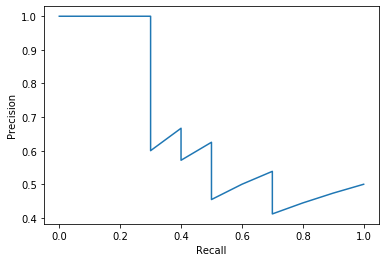

In [23]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
print(thresholds)

In [53]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, predictions)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.78
